In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [5]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
import gensim.downloader as api
from sklearn.decomposition import PCA
# Load Word2Vec model trained on Google News dataset
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')

# Define a function to get the vector representation of a document
def document_vector(doc):
    # Remove punctuation and tokenize the document
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in punctuation_set]
    # Filter out tokens that are not in the Word2Vec model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.key_to_index]
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the mean of word vectors for tokens in the document
    return np.mean(word2vec_model[tokens], axis=0)

# Obtain Word2Vec embeddings for each document
print("Obtaining Word2Vec embeddings for each document...")
word2vec_embeddings = np.array([document_vector(doc) for doc in processed_data])
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(word2vec_embeddings)


Vectorizing the text data...
Loading Word2Vec model...
Obtaining Word2Vec embeddings for each document...


In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

# Objective function: Inertia (Sum of squared distances to nearest cluster center)
def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia, labels


import numpy as np
from scipy.special import gamma  # Import gamma from scipy.special

def levy_flight(mu, size):
    sigma = (gamma(1 + mu) * np.sin(np.pi * mu / 2) / 
             (gamma((1 + mu) / 2) * mu * 2 ** ((mu - 1) / 2))) ** (1 / mu)
    u = np.random.normal(0, sigma, size)
    v = np.random.normal(0, 1, size)
    step = u / np.abs(v) ** (1 / mu)
    return step

# Cuckoo Search Update
def cuckoo_search(nests, best_nest, data, lb, ub, levy_size=0.01):
    new_nests = np.copy(nests)
    for i in range(len(nests)):
        step_size = levy_flight(1.5, nests[i].shape) * levy_size
        new_nests[i] += step_size * (nests[i] - best_nest)
        new_nests[i] = np.clip(new_nests[i], lb, ub)  # Ensure within bounds
        if compute_inertia(new_nests[i].reshape(-1, data.shape[1]), data) < compute_inertia(nests[i].reshape(-1, data.shape[1]), data):
            nests[i] = new_nests[i]
    return nests

# Particle Swarm Optimization Update
def pso_update(particles, velocities, pbest_positions, gbest_position, w=0.5, c1=0.8, c2=0.9):
    for i in range(len(particles)):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities[i] = w * velocities[i] + c1 * r1 * (pbest_positions[i] - particles[i]) + c2 * r2 * (gbest_position - particles[i])
        particles[i] += velocities[i]
    return particles, velocities

# Hybrid Cuckoo-PSO-KMeans
def cuckoo_pso_kmeans(data, n_clusters, n_particles=10, max_iter=100):
    lb, ub = np.min(data, axis=0), np.max(data, axis=0)
    dims = data.shape[1]

    # Initialize nests (centroids) randomly for Cuckoo Search
    nests = np.random.uniform(lb, ub, (n_particles, n_clusters, dims))
    
    # Initialize particles and velocities for PSO
    particles = np.random.uniform(lb, ub, (n_particles, n_clusters, dims))
    velocities = np.zeros_like(particles)
    
    # Best positions and scores for PSO
    pbest_positions = np.copy(particles)
    pbest_scores = np.array([compute_inertia(p.reshape(-1, dims), data)[0] for p in pbest_positions])    
    gbest_position = pbest_positions[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)
    
    for iteration in range(max_iter):
        # Cuckoo Search on nests
        nests = cuckoo_search(nests, gbest_position.reshape(-1, dims), data, lb, ub)
        
        # Update PSO particles
        particles, velocities = pso_update(particles, velocities, pbest_positions, gbest_position, w=0.5, c1=0.8, c2=0.9)
        
        # Evaluate and Update Best Scores and Positions
        for i in range(n_particles):
            current_score ,_= compute_inertia(particles[i].reshape(-1, dims), data)
            if current_score < pbest_scores[i]:
                pbest_scores[i] = current_score
                pbest_positions[i] = particles[i]
                if current_score < gbest_score:
                    gbest_score = current_score
                    gbest_position = particles[i]
                    
        # Optional: Here, you can integrate a KMeans refinement step
        
    # Final KMeans to refine centroids
    final_kmeans = KMeans(n_clusters=n_clusters, init=gbest_position.reshape(-1, dims), n_init=1)
    final_kmeans.fit(data)
    
    return final_kmeans.cluster_centers_, final_kmeans.labels_, final_kmeans.inertia_


n_clusters = 2
best_centroids, labels, best_score = cuckoo_pso_kmeans(tfidf_matrix_reduced, n_clusters)
print("Best Centroids:", best_centroids)
silhouette = silhouette_score(tfidf_matrix_reduced, labels)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, labels)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Best Centroids: [[ 7.59948464e-01 -5.28951043e-03 -7.18221621e-03 -1.75571767e-03
  -5.96605590e-03  6.71478284e-03 -2.41164724e-04 -1.66443123e-03
  -4.93760896e-04 -2.12049056e-03  1.88429814e-04  1.05280538e-04
   6.73650468e-04 -2.75011784e-04 -1.02506335e-03  6.40347883e-04
  -1.17988142e-03 -1.29862752e-04  4.53295314e-05 -5.74975382e-04
  -2.85121827e-04 -9.24679449e-05 -3.54029862e-04 -6.85881649e-04
   3.64508607e-04 -3.11794110e-04 -5.41162166e-04 -3.13886352e-04
  -7.91975808e-05 -2.68749597e-04 -1.53805456e-04 -2.64045121e-05
  -6.38941868e-05 -7.66804848e-05  2.28426460e-04  5.89130260e-05
  -7.23470231e-05 -1.64984143e-04  1.07793085e-05 -1.40622736e-04
   7.19869399e-05 -2.52393239e-04  1.11604642e-04 -2.06465697e-05
   8.79870392e-05 -1.74928765e-04  2.02140495e-05 -1.36496616e-04
  -2.15430981e-05 -1.40291452e-04  6.55749351e-05 -4.37721377e-05
   3.16832318e-04  6.39792128e-05 -1.90740120e-04  4.67290638e-05
   6.96385617e-05 -5.95520601e-05 -1.53385260e-04  8.1903764

In [7]:
from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    best_centroids, labels, best_score = cuckoo_pso_kmeans(tfidf_matrix_reduced, n_clusters)
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, labels)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)
    # Store metrics
    silhouette_scores.append(silhouette)
    print(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

0.10264296725025383
0.057571357059855735
0.08957484591411234
0.08963148988926496
0.0596103924692217
0.05903529800069993
0.07299857639955168
0.07287371147686639
0.0714905650847773
0.06476070625580252
0.07254627534728936
0.06640762027788244
0.07243832262243684
0.07028699617146915
0.06566793179141638
0.06950360398740824
0.06492553007020507
0.0659150655783029
0.06527426797484596


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_26200\2666552752.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_26200\2666552752.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


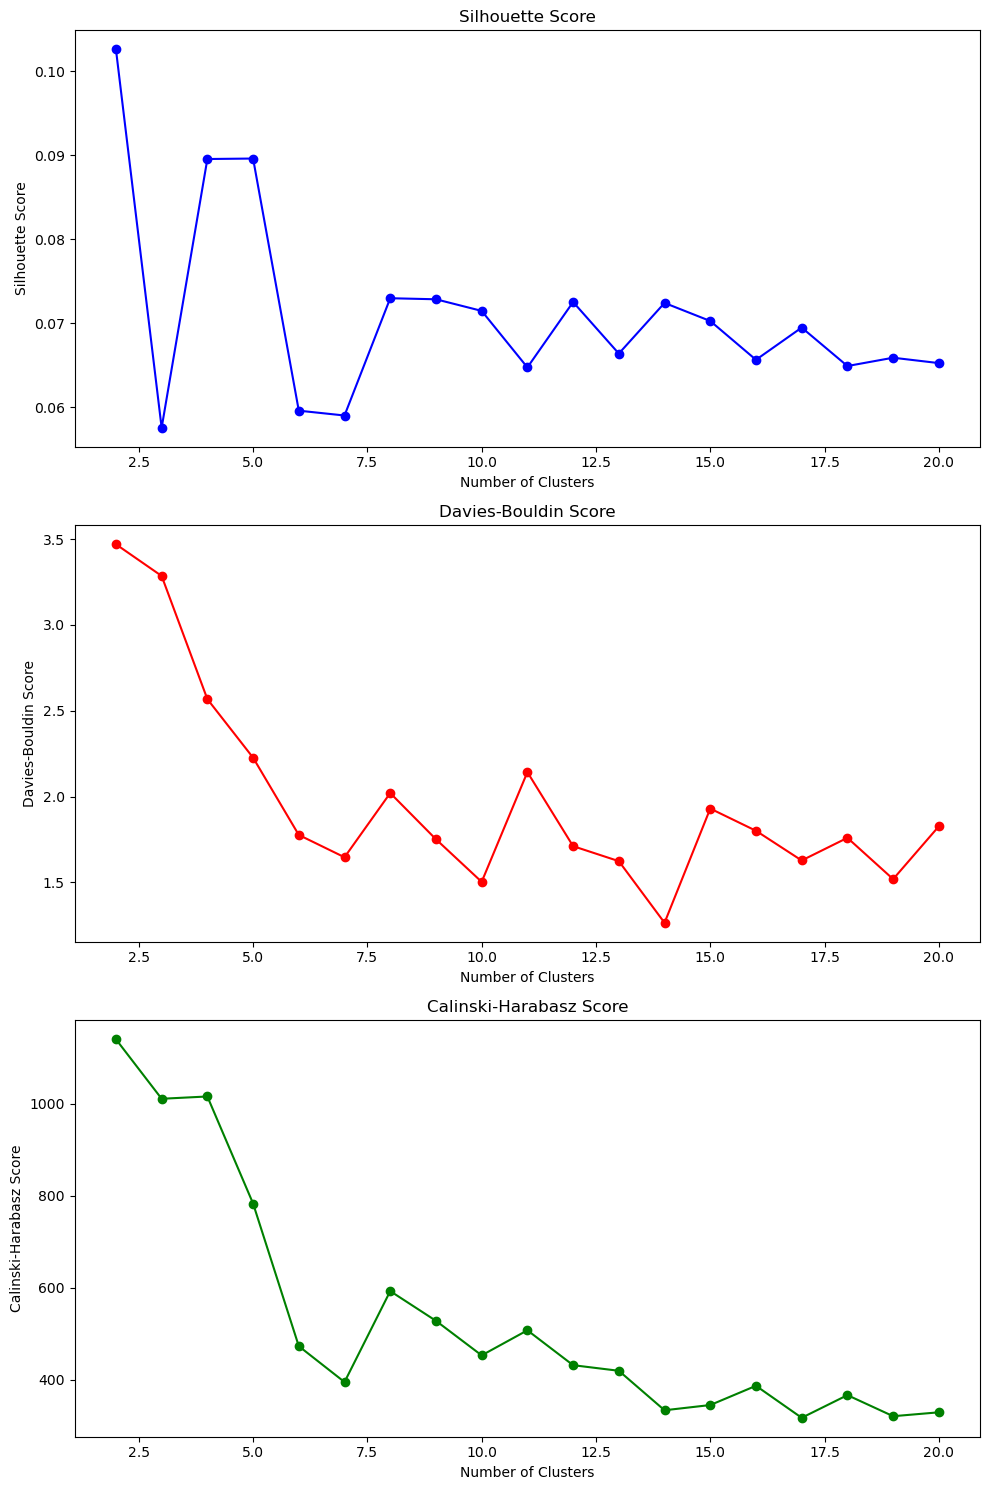

In [8]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_word2vec-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_word2vec-Kmeans.png")
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.102643,3.469608,1140.291565
3,0.057571,3.284956,1010.989352
4,0.089575,2.567444,1015.978457
5,0.089631,2.226263,783.431596
6,0.059610,1.776066,473.466334
7,0.059035,1.646054,395.535510
8,0.072999,2.020205,593.095781
9,0.072874,1.750960,528.555516
10,0.071491,1.502717,453.485757
11,0.064761,2.142035,507.946736


In [10]:
df.to_csv('Word2vec_PSO+Cuckoo_Scores.csv')